In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 

In [2]:
df = pd.read_csv('coffee.csv')
display(df.head())
display(df.shape)

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


(5746, 7)

,Close
635,209.25
636,211.25
637,199.20
638,203.70
639,219.10


,Close
669,240.50
670,239.15
671,239.10
672,236.35
673,228.42


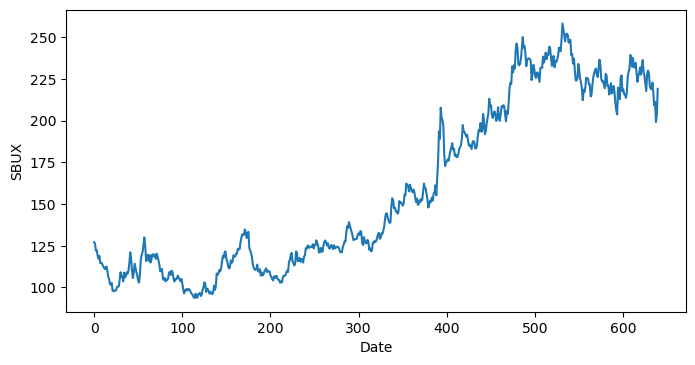

In [3]:
df = pd.read_csv('coffee.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True) 
start_dt = pd.to_datetime('01.01.2020')

df = df.query('Date>= @start_dt')
df.sort_values(by=['Date'], inplace=True, ascending=True, ignore_index=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Currency','Date'], inplace=True)

# Сделаем train и test выборки
x = len(df)
size = int(x * 0.95)
index = x - size
df_train = df.iloc[:size]
df_test = df.iloc[size:]




display(df_train.tail())
display(df_test.tail())
# df_train.set_index('Date', inplace=True)
# df_test.set_index('Date', inplace=True)
plt.xlabel('Date')
plt.ylabel('SBUX')
plt.plot(df_train)

![alt text](time.png "Title")

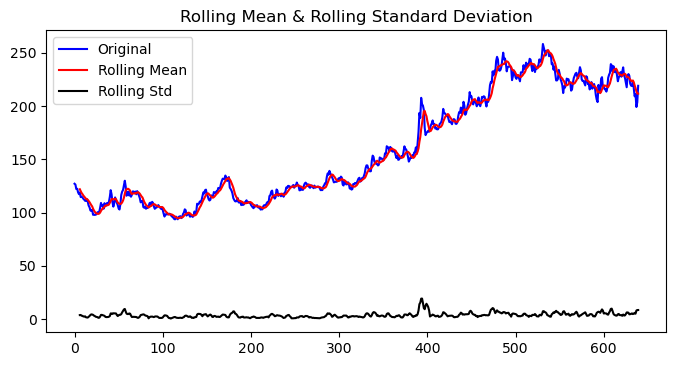

In [4]:
rolling_mean = df_train.rolling(window = 7).mean()
rolling_std = df_train.rolling(window = 7).std()
plt.plot(df_train, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [5]:
result = adfuller(df_train['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.581309722175845
p-value: 0.8751495843248984
Critical Values:
	1%: -3.4407064257994495
	5%: -2.866109523416927
	10%: -2.5692034867497937


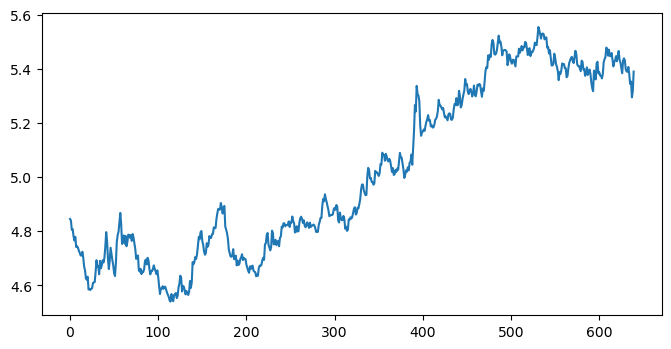

In [6]:
df_log = np.log(df_train)
plt.plot(df_log)

In [7]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Close'])
    print('ADF Statistic: {}'.format(result[0]))
    if result[1] < 0.05:
        p_res = 'is less then 0.05'
    else:
        p_res = 'is more then 0.05'
    print(f'p-value: {result[1]} - {p_res}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

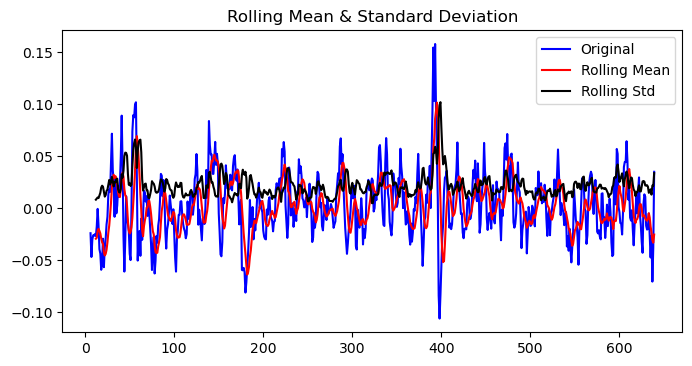

ADF Statistic: -10.98917176595027
p-value: 7.131589420901323e-20 - is less then 0.05
Critical Values:
	1%: -3.4407724517110783
	5%: -2.866138605582151
	10%: -2.569218982111363


In [8]:
rolling_mean = df_log.rolling(window=7).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

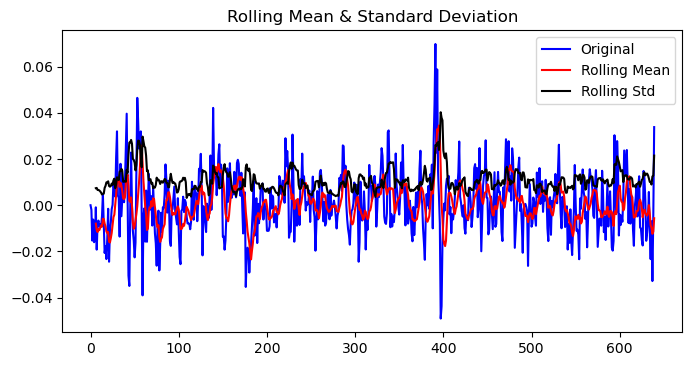

ADF Statistic: -11.244631893017262
p-value: 1.7721086166547395e-20 - is less then 0.05
Critical Values:
	1%: -3.4406737255613256
	5%: -2.866095119842903
	10%: -2.5691958123689727


In [9]:
rolling_mean_exp_decay = df_log.ewm(halflife=1, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

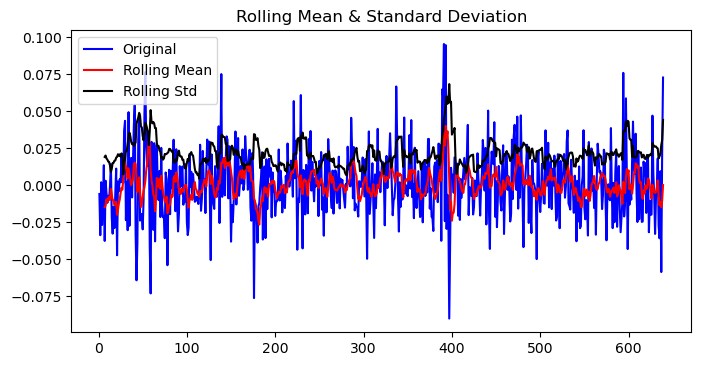

ADF Statistic: -12.30227004187765
p-value: 7.404267408674734e-23 - is less then 0.05
Critical Values:
	1%: -3.4407064257994495
	5%: -2.866109523416927
	10%: -2.5692034867497937


In [10]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

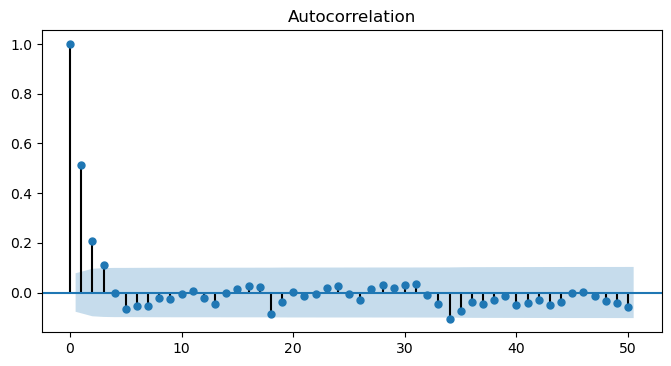

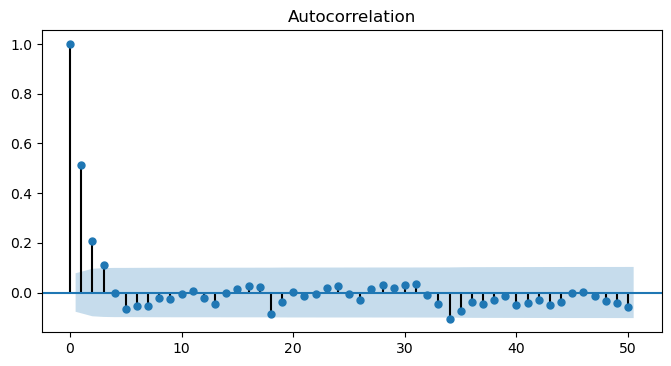

In [11]:
# plot the auto correlation
plot_acf(df_log_exp_decay, lags=50)

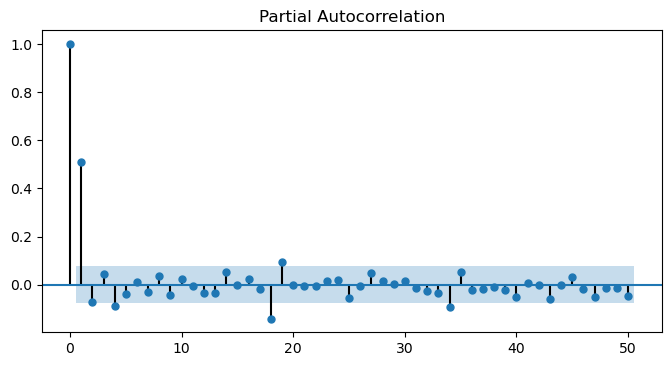

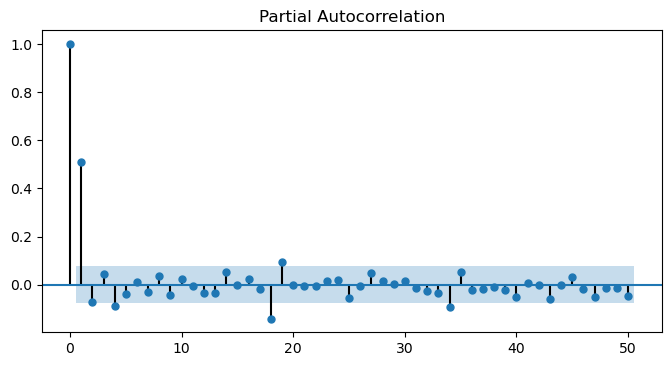

In [12]:
plot_pacf(df_log_exp_decay, lags=50)

![alt text](AR.png "Title")

![alt text](MA.png "Title")

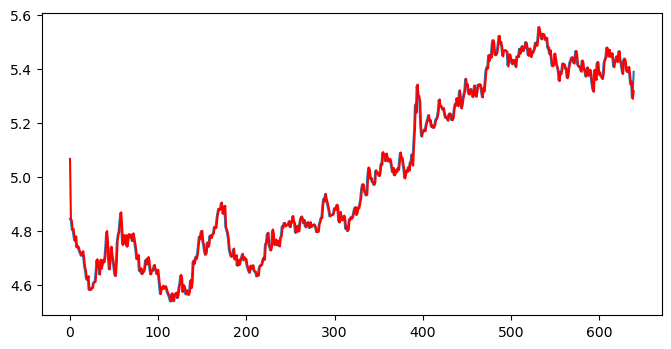

In [13]:
decomposition = seasonal_decompose(x=df_log['Close'], model='additive', extrapolate_trend='freq', period=int(7))
model = ARIMA(df_log, order=(1,0,1))
results = model.fit(disp=-1)
plt.plot(df_log)
plt.plot(results.fittedvalues, color='red')

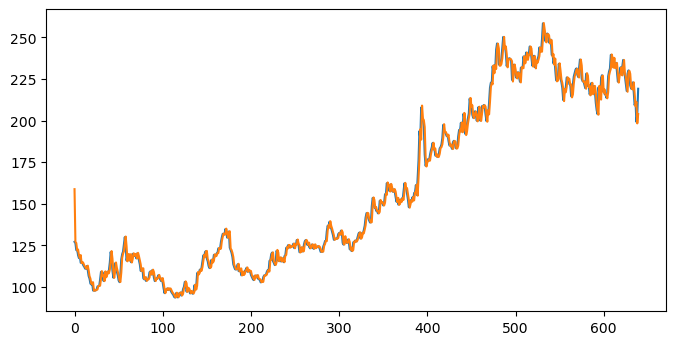

In [14]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = np.exp(predictions_ARIMA_diff)
plt.plot(df_train)
plt.plot(predictions_ARIMA)


In [ ]:
index

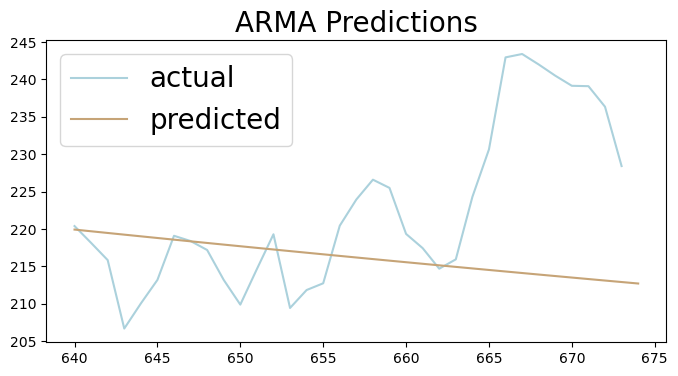

In [15]:
# generate predictions
df_pred = results.predict(size,size+index)    
df_pred_exp = np.exp(df_pred)
# plot actual vs. predicted
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test['Close'], label='actual', color='#ABD1DC')
plt.plot(df_pred_exp, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(df_test['Close'], df_pred_exp[:-1]))
print("RMSE:", round(rmse,2))

RMSE: 13.74


In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  640
Model:                     ARMA(1, 1)   Log Likelihood                1506.684
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 27 Apr 2023   AIC                          -3005.368
Time:                        19:32:02   BIC                          -2987.523
Sample:                             0   HQIC                         -2998.442
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0674      0.217     23.320      0.000       4.642       5.493
ar.L1.Close     0.9968      0.003    394.178      0.000       0.992       1.002
ma.L1.Close     0.0669      0.043      1.552      0.121      -0.018       0.151
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0032           +0.0000j            1.0032            0.0000
MA.1          -14.9552           +0.0000j           14.9552            0.5000
-----------------------------------------------------------------------------
"""